In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

In [2]:
# 한글 폰트 설정
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

## 이전 자치구 수요 불안정을 분석을 통한 인사이트
- |대여-반납|의 변동이 크고 특정시간때에는 자전거가 부족하고 특정시간때는 과잉으로 몰리는 현상이 뚜렷함
- 항상 빈대여소의 비율이 높음


In [3]:
loc_merge = pd.read_csv("./data/merged_df.csv")

In [4]:
loc_merge.head(6)

,대여소_ID,주간,시간대,대여소번호,대여건수,반납건수,총이용건수,잔여자전거수,동일대여소대여반납,중구내대여반납,유출량,유입량,위도,경도
0,ST-116,주말,0,300,1,2,3,5,0,0,1,2,37.56805,126.969231
1,ST-116,주말,1,300,1,1,2,7,0,0,1,1,37.56805,126.969231
2,ST-116,주말,2,300,4,2,6,6,0,1,3,0,37.56805,126.969231
3,ST-116,주말,3,300,0,0,0,5,0,0,0,0,37.56805,126.969231
4,ST-116,주말,4,300,0,0,0,5,0,0,0,0,37.56805,126.969231
5,ST-116,주말,5,300,0,1,1,5,0,0,0,1,37.56805,126.969231


In [5]:
loc_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   대여소_ID     4320 non-null   object 
 1   주간         4320 non-null   object 
 2   시간대        4320 non-null   int64  
 3   대여소번호      4320 non-null   int64  
 4   대여건수       4320 non-null   int64  
 5   반납건수       4320 non-null   int64  
 6   총이용건수      4320 non-null   int64  
 7   잔여자전거수     4320 non-null   int64  
 8   동일대여소대여반납  4320 non-null   int64  
 9   중구내대여반납    4320 non-null   int64  
 10  유출량        4320 non-null   int64  
 11  유입량        4320 non-null   int64  
 12  위도         4320 non-null   float64
 13  경도         4320 non-null   float64
dtypes: float64(2), int64(10), object(2)
memory usage: 472.6+ KB


In [6]:
loc_merge.describe()

,시간대,대여소번호,대여건수,반납건수,총이용건수,잔여자전거수,동일대여소대여반납,중구내대여반납,유출량,유입량,위도,경도
count,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000
mean,11.500000,2014.088889,23.287269,22.100694,45.387963,39.089815,1.463889,9.421296,12.402083,11.215278,37.562353,126.989048
std,6.922988,2189.562047,40.250859,38.216457,75.580813,59.352494,3.615919,15.205966,25.114863,22.021143,0.004693,0.016102
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.547585,126.964142
25%,5.750000,384.000000,2.000000,2.000000,5.000000,7.000000,0.000000,1.000000,1.000000,1.000000,37.559692,126.974838
50%,11.500000,470.500000,9.000000,8.000000,18.000000,19.000000,0.000000,4.000000,4.000000,4.000000,37.562531,126.987088
75%,17.250000,4772.000000,26.000000,25.000000,51.250000,43.000000,1.000000,11.000000,12.000000,12.000000,37.566223,127.005539
max,23.000000,6058.000000,505.000000,486.000000,902.000000,500.000000,45.000000,148.000000,370.000000,315.000000,37.571621,127.023933


# 컬럼별로 시간에 따른 전체적인 지표를 확인

## 총이용건수 지표
- 모든 대여소의 이용건수의 합으로 지표를 봄

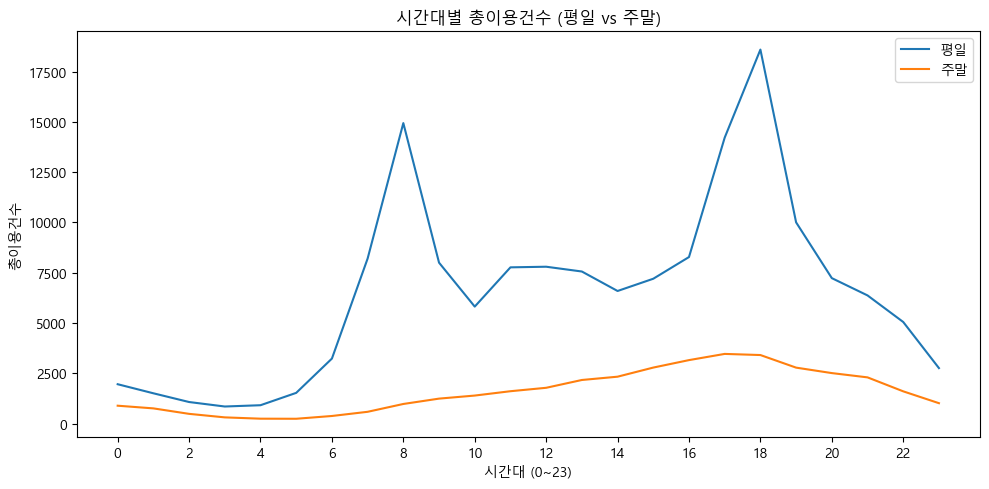

In [7]:
per_time = loc_merge.groupby(["주간","시간대"], as_index=False)[["대여건수","반납건수","총이용건수"]].sum()
prof_line = per_time.pivot(index="시간대", columns="주간", values="총이용건수").reindex(range(24))   # 0~23 보장.fillna(0)

plt.figure(figsize=(10,5))
plt.plot(prof_line.index, prof_line.get("평일", pd.Series(0, index=prof_line.index)), label="평일")
plt.plot(prof_line.index, prof_line.get("주말", pd.Series(0, index=prof_line.index)), label="주말")
plt.title("시간대별 총이용건수 (평일 vs 주말)")
plt.xlabel("시간대 (0~23)")
plt.ylabel("총이용건수")
plt.xticks(range(0,24,2))
plt.legend()
plt.tight_layout()
plt.show()

- 평일 오전 7시부터 8시까지 이용량이 크게 증폭함, 그리고 다시 16시부터 18시까지 이용량이 크게 줄어듦
- 점심 11시부터 15시까지 완만한 이용증가를 보임

- 평일의 이용량이 주말의 이용량보다는 뚜렷하게 많음

- 주말에는 오후 14시부터 점차적으로 이용량이 증가하다가 18시부터는 다시 줄어듦

## 잔여 자전거의 수 지표
- 모든 댜여소의 평균으로 지표를 봄

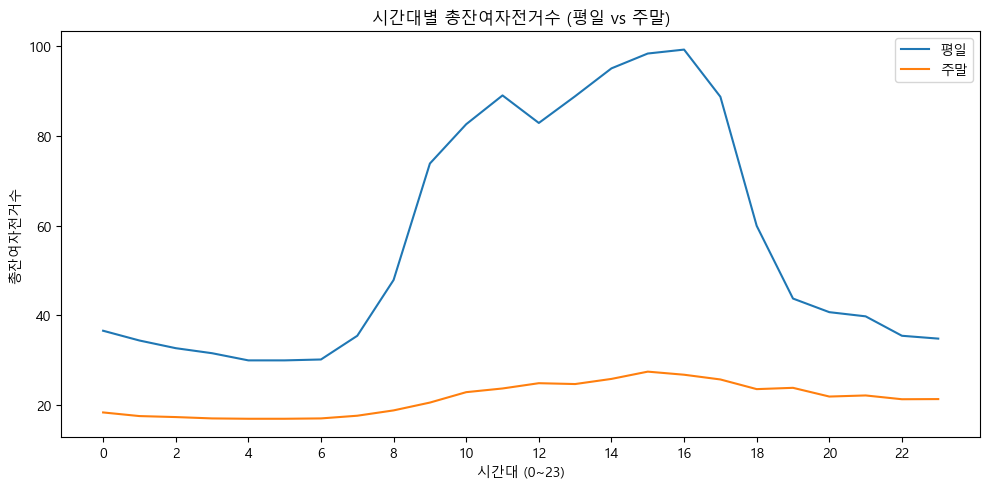

In [8]:
per_time = loc_merge.groupby(["주간","시간대"], as_index=False)["잔여자전거수"]. mean()

prof_line = (
    per_time.pivot(index="시간대", columns="주간", values="잔여자전거수")
             .reindex(range(24))
             .fillna(0)
)

plt.figure(figsize=(10,5))
plt.plot(prof_line.index, prof_line["평일"], label="평일")
plt.plot(prof_line.index, prof_line["주말"], label="주말")
plt.title("시간대별 총잔여자전거수 (평일 vs 주말)")
plt.xlabel("시간대 (0~23)")
plt.ylabel("총잔여자전거수")
plt.xticks(range(0,24,2))
plt.legend()
plt.tight_layout()
plt.show()


- 오전 7시 이후로 중구의 잔여 자전거의 수가 점점 많아짐
- 오후 16시 이후로는 잔여 자전거의 수가 급격히 줄어듦

- 16시 이후로 급격히 줄어들어서 잔여 자전거의 수가 회복되지 않다가 오전 8시 이후에 출근시간때부터 회복함

## 동일 대여소 대여, 반납의 수
- 모든 대여소의 동일 대여소에서 대여, 반납한 합으로 지표를 봄

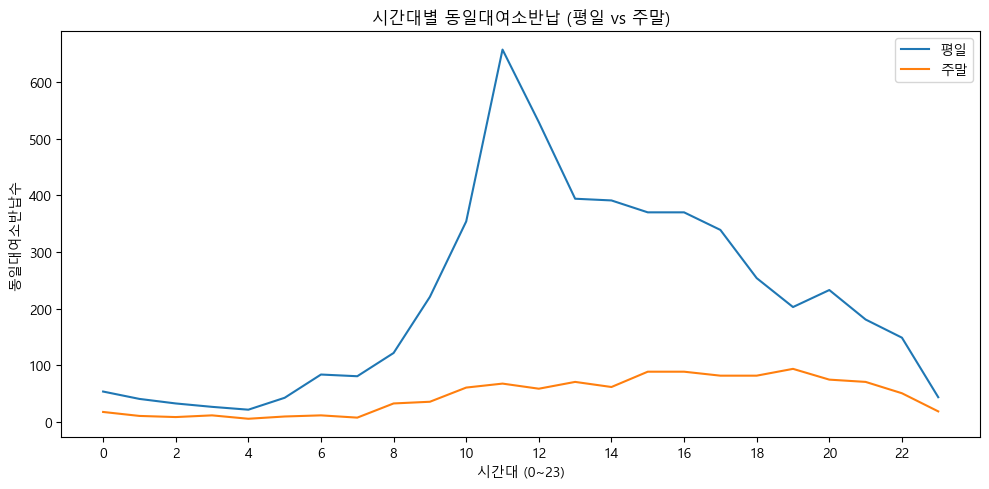

In [9]:
per_time = loc_merge.groupby(["주간","시간대"], as_index=False)["동일대여소대여반납"].sum()
prof_line = per_time.pivot(index="시간대", columns="주간", values="동일대여소대여반납").reindex(range(24))   # 0~23 보장.fillna(0)

plt.figure(figsize=(10,5))
plt.plot(prof_line.index, prof_line.get("평일", pd.Series(0, index=prof_line.index)), label="평일")
plt.plot(prof_line.index, prof_line.get("주말", pd.Series(0, index=prof_line.index)), label="주말")
plt.title("시간대별 동일대여소반납 (평일 vs 주말)")
plt.xlabel("시간대 (0~23)")
plt.ylabel("동일대여소반납수")
plt.xticks(range(0,24,2))
plt.legend()
plt.tight_layout()
plt.show()

- 오전 11시정도에 동일 대여소 반납의 수가 많음
- 생활관 내 단거리 순환 이용이 점심에 발생함

## 유출량, 유입량
- 모든 대여소에서 다른 자치구로 유출되는 자전거의 수, 다른 자치구로부터의 유입되는 수를 합으로 봄

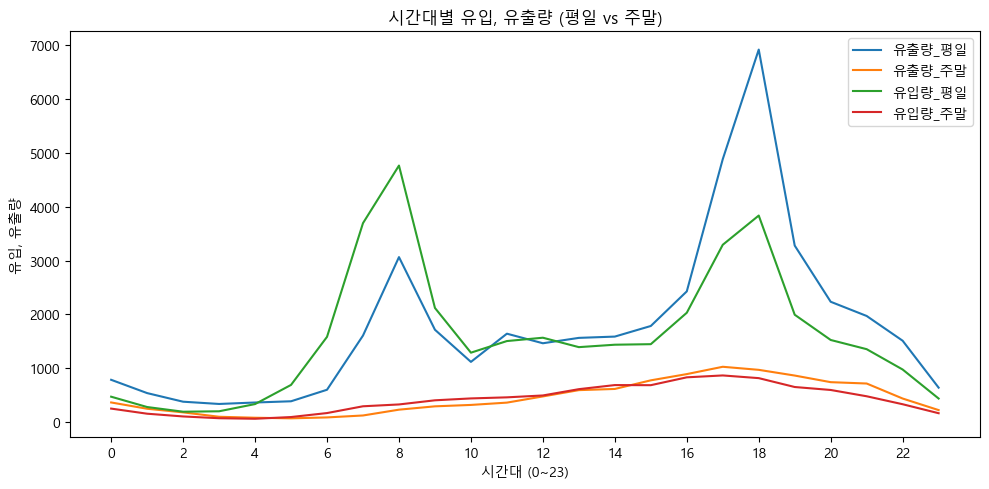

In [10]:
per_time_out = loc_merge.groupby(["주간","시간대"], as_index=False)["유출량"].sum()
prof_line_out = per_time_out.pivot(index="시간대", columns="주간", values="유출량").reindex(range(24))   # 0~23 보장.fillna(0)

per_time_in = loc_merge.groupby(["주간","시간대"], as_index=False)["유입량"].sum()
prof_line_in = per_time_in.pivot(index="시간대", columns="주간", values="유입량").reindex(range(24))   # 0~23 보장.fillna(0)

plt.figure(figsize=(10,5))

plt.plot(prof_line_out.index, prof_line_out.get("평일", pd.Series(0, index=prof_line.index)), label="유출량_평일")
plt.plot(prof_line_out.index, prof_line_out.get("주말", pd.Series(0, index=prof_line.index)), label="유출량_주말")

plt.plot(prof_line_in.index, prof_line_in.get("평일", pd.Series(0, index=prof_line.index)), label="유입량_평일")
plt.plot(prof_line_in.index, prof_line_in.get("주말", pd.Series(0, index=prof_line.index)), label="유입량_주말")

plt.title("시간대별 유입, 유출량 (평일 vs 주말)")
plt.xlabel("시간대 (0~23)")
plt.ylabel("유입, 유출량")
plt.xticks(range(0,24,2))
plt.legend()
plt.tight_layout()
plt.show()

- 오전 6시부터 8시까지, 16시부터 18시까지는 유출량, 유입량 둘 다 증가(이용량 지표에서 봤드시 출근시간때의 이용량이 뚜렷히 증가)
- 출근시간때에는 유입량 > 유출량임, 퇴근시간때는 유출량 >> 유입량임
- 출근시간때를 제외하고는 유입보다 유출되는 양이 많음

## 전체 컬럼의 시간대별 지표를 통한 분석
- 출퇴근 + 상권/관광 복합지로써, 아침과 저녁에 뚜렷한 피크가 존재
- 대부분 이용건수가 증가하게 된다면 잔여자전거의 수가 급격히 감소하여 고갈 위험이 높음
- 특히 퇴근시간때(17 ~ 19)에는 유입보다 유출의 양이 압도적으로 많아 퇴근 시간 이후 고갈 발생빈도가 높음
- 아침에 출근시간때의 유입을 제외하면 모든 시간떄에서는 유출량 > 유입량, 오전 출근시간 이후 퇴근 시간이전을 제외하고는 잔여자전거수가 낮아 고갈 위험이 높음
- 동일 대여소의 반납이 평일 점심이 많음 -> 업무 생활권 내 단거리 순환 수요가 중심
- 중구는 출, 퇴근 장거리 수요 + 낮시간 단거리 수요 + 관광상권형 수요가 공존하는 복합적 이용패턴을 보임

# 위치별, 대여소별 따릉이 특성

- 지금은 시간대별 전반적인 중구의 따릉이 수요에 대해서 확인해봄
- 전반적인 중구의 따릉이 수요을 통해서 어느 대여소가 어떤 뚜렷한 특이점이 존재하는지, 클러스터별 위치를 확인해서 위치별로 특이점이 존재가 있는지 세부적인 분석

In [11]:
station_summary = loc_merge.groupby(["대여소_ID", "대여소번호"], as_index=False).agg({
    "대여건수": "sum",
    "반납건수": "sum",
    "총이용건수": "sum",
    "잔여자전거수": ["mean", "std"],
    "유출량": "sum",
    "유입량": "sum",
    "동일대여소대여반납": "sum"
})
station_summary.columns = [
    "대여소_ID", "대여소번호",
    "총대여건수", "총반납건수", "총이용건수",
    "평균_잔여자전거수", "표준편차_잔여자전거수",
    "총유출량", "총유입량", "총동일대여소반납"
]

In [12]:
station_summary.head()

,대여소_ID,대여소번호,총대여건수,총반납건수,총이용건수,평균_잔여자전거수,표준편차_잔여자전거수,총유출량,총유입량,총동일대여소반납
0,ST-116,300,1104,1137,2241,13.812500,13.229008,573,648,43
1,ST-126,310,1548,1387,2935,27.708333,48.734172,979,758,67
2,ST-134,318,1403,1365,2768,50.166667,88.466446,833,808,98
3,ST-136,320,1727,1712,3439,51.062500,78.981928,1008,1019,180
4,ST-137,321,1308,1311,2619,41.625000,58.341484,667,640,136


In [13]:
station_summary["순유출량"] = station_summary["총유출량"] - station_summary["총유입량"]
station_summary["순유입량"] = station_summary["총유입량"] - station_summary["총유출량"]
station_summary["동일반납비율"] = station_summary["총동일대여소반납"] / station_summary["총이용건수"]

In [14]:
station_summary["표준편차_잔여자전거수"] = station_summary["표준편차_잔여자전거수"].fillna(0.0)
station_summary["동일반납비율"] = station_summary["동일반납비율"].fillna(0.0)

In [15]:
station_summary.head()

,대여소_ID,대여소번호,총대여건수,총반납건수,총이용건수,평균_잔여자전거수,표준편차_잔여자전거수,총유출량,총유입량,총동일대여소반납,순유출량,순유입량,동일반납비율
0,ST-116,300,1104,1137,2241,13.812500,13.229008,573,648,43,-75,75,0.019188
1,ST-126,310,1548,1387,2935,27.708333,48.734172,979,758,67,221,-221,0.022828
2,ST-134,318,1403,1365,2768,50.166667,88.466446,833,808,98,25,-25,0.035405
3,ST-136,320,1727,1712,3439,51.062500,78.981928,1008,1019,180,-11,11,0.052341
4,ST-137,321,1308,1311,2619,41.625000,58.341484,667,640,136,27,-27,0.051928


In [16]:
feature_cols = [
    "총이용건수",
    "평균_잔여자전거수",
    "표준편차_잔여자전거수",
    "총유출량",
    "총유입량",
    "순유출량",
    "동일반납비율",
]

In [17]:
corr_matrix = station_summary[feature_cols].corr()

In [18]:
corr_matrix

,총이용건수,평균_잔여자전거수,표준편차_잔여자전거수,총유출량,총유입량,순유출량,동일반납비율
총이용건수,1.000000,0.787647,0.565198,0.969893,0.973504,0.439951,0.327985
평균_잔여자전거수,0.787647,1.000000,0.714888,0.789584,0.746326,0.596221,0.292204
표준편차_잔여자전거수,0.565198,0.714888,1.000000,0.597861,0.571132,0.420398,0.244151
총유출량,0.969893,0.789584,0.597861,1.000000,0.986608,0.541799,0.206715
총유입량,0.973504,0.746326,0.571132,0.986608,1.000000,0.397451,0.232771
순유출량,0.439951,0.596221,0.420398,0.541799,0.397451,1.000000,-0.036540
동일반납비율,0.327985,0.292204,0.244151,0.206715,0.232771,-0.036540,1.000000


In [19]:
x = station_summary[feature_cols]

In [20]:
scaler = StandardScaler()

In [21]:
x_scaled = scaler.fit_transform(x)

# 클러스터를 두가지로 나눠봄

In [22]:
model = KMeans(n_clusters = 2, n_init = 10, random_state = 26)

In [23]:
labels = model.fit_predict(x_scaled)

C:\Users\dbtjd\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [24]:
result = station_summary.copy()

In [25]:
result["cluster"] = labels

In [26]:
result["cluster"].unique()

array([0, 1])

In [27]:
cluster_means = result.groupby("cluster")[feature_cols].mean(numeric_only=True)

In [28]:
cluster_means

,총이용건수,평균_잔여자전거수,표준편차_잔여자전거수,총유출량,총유입량,순유출량,동일반납비율
cluster,,,,,,,
0,1766.743902,32.144055,28.712058,456.5,419.036585,37.463415,0.027189
1,6400.375000,110.283854,114.067811,2018.0,1761.125000,256.875000,0.034117


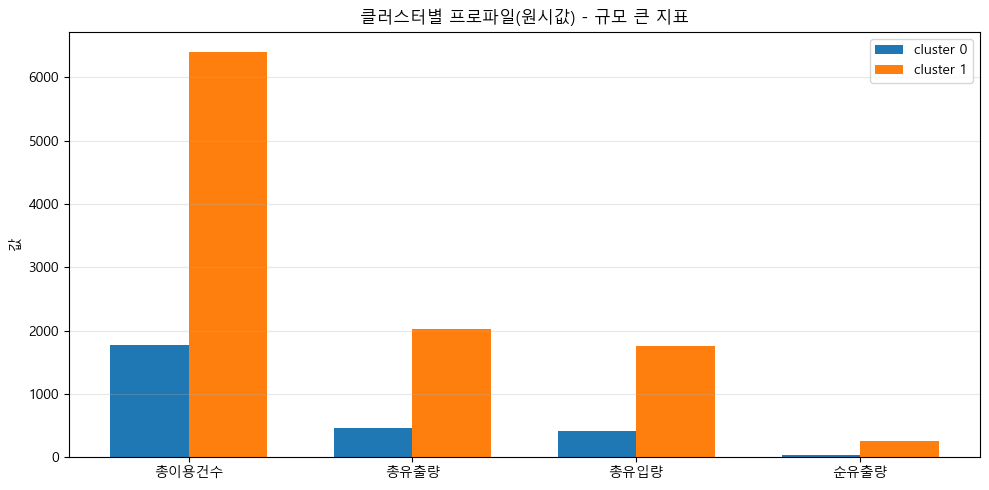

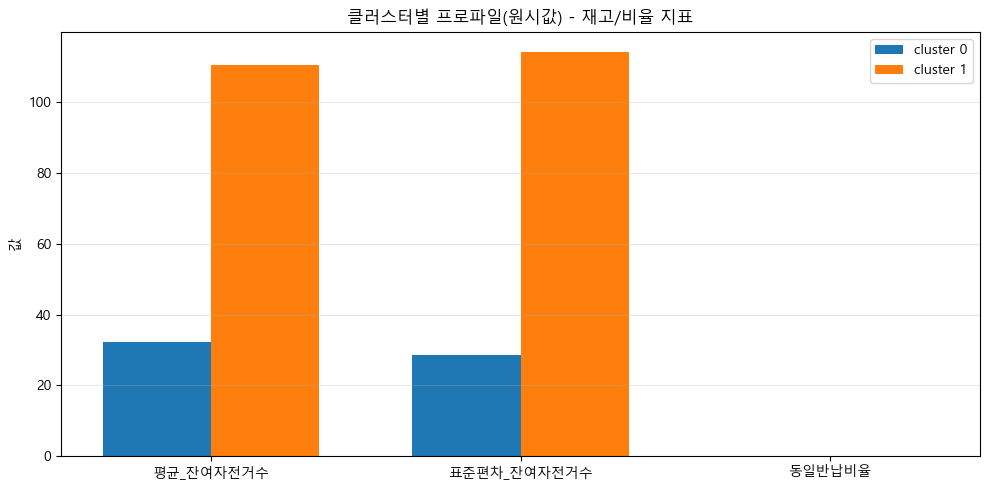

In [29]:
def plot_grouped_bars(df, cols, title):
    x = np.arange(len(cols))
    w = 0.35

    plt.figure(figsize=(10,5))
    plt.bar(x - w/2, df.loc[0, cols].values, width=w, label="cluster 0")
    plt.bar(x + w/2, df.loc[1, cols].values, width=w, label="cluster 1")

    plt.xticks(x, cols, rotation=0)
    plt.title(title)
    plt.ylabel("값")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

# 1) 규모 큰 지표
big_cols = ["총이용건수", "총유출량", "총유입량", "순유출량"]
plot_grouped_bars(cluster_means, big_cols, "클러스터별 프로파일(원시값) - 규모 큰 지표")

# 2) 재고/비율 지표
small_cols = ["평균_잔여자전거수", "표준편차_잔여자전거수", "동일반납비율"]
plot_grouped_bars(cluster_means, small_cols, "클러스터별 프로파일(원시값) - 재고/비율 지표")

# 클러스터 1

In [30]:
result[result["cluster"] == 1]

,대여소_ID,대여소번호,총대여건수,총반납건수,총이용건수,평균_잔여자전거수,표준편차_잔여자전거수,총유출량,총유입량,총동일대여소반납,순유출량,순유입량,동일반납비율,cluster
12,ST-1440,431,5028,4934,9962,162.812500,86.317981,3240,2856,466,384,-384,0.046778,1
18,ST-1668,433,2398,1936,4334,68.583333,123.525832,1713,1370,61,343,-343,0.014075,1
33,ST-1780,474,3174,2367,5541,149.020833,109.263392,1747,1315,129,432,-432,0.023281,1
42,ST-185,370,2964,2729,5693,99.312500,161.610927,1536,1394,246,142,-142,0.043211,1
50,ST-198,383,6000,6085,12085,135.416667,59.264583,3508,3304,379,204,-204,0.031361,1
52,ST-2422,3013,1748,1763,3511,92.666667,171.945728,1038,1028,168,10,-10,0.047850,1
72,ST-2693,4796,2326,2030,4356,87.000000,138.533812,1394,1078,146,316,-316,0.033517,1
76,ST-2903,4798,2857,2864,5721,87.458333,62.080236,1968,1744,188,224,-224,0.032861,1


In [31]:
usage_type = result[result["cluster"] == 1]["대여소_ID"].unique()

# 1번 클러스터 

- 다른 클러스터에 비해서 이용건수가 매우 많음 유입, 유출, 자전거의 수가 매우 많음
- 중구에서도 매우 활발하게 이용되는 곳
- 출퇴근 지역을 예상

In [32]:
usage_type

array(['ST-1440', 'ST-1668', 'ST-1780', 'ST-185', 'ST-198', 'ST-2422',
       'ST-2693', 'ST-2903'], dtype=object)

In [33]:
usage_station = loc_merge[loc_merge["대여소_ID"].isin(usage_type)]

In [34]:
usage_station

,대여소_ID,주간,시간대,대여소번호,대여건수,반납건수,총이용건수,잔여자전거수,동일대여소대여반납,중구내대여반납,유출량,유입량,위도,경도
576,ST-1440,주말,0,431,31,30,61,119,3,5,23,26,37.571014,127.019745
577,ST-1440,주말,1,431,27,30,57,118,4,12,11,16,37.571014,127.019745
578,ST-1440,주말,2,431,20,19,39,127,1,4,15,10,37.571014,127.019745
579,ST-1440,주말,3,431,8,18,26,128,2,2,4,12,37.571014,127.019745
580,ST-1440,주말,4,431,15,8,23,138,1,0,14,5,37.571014,127.019745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3691,ST-2903,평일,19,4798,194,207,401,139,15,29,150,121,37.571621,127.022041
3692,ST-2903,평일,20,4798,168,152,320,146,11,27,130,96,37.571621,127.022041
3693,ST-2903,평일,21,4798,156,151,307,152,11,26,119,90,37.571621,127.022041
3694,ST-2903,평일,22,4798,117,127,244,145,3,22,92,64,37.571621,127.022041


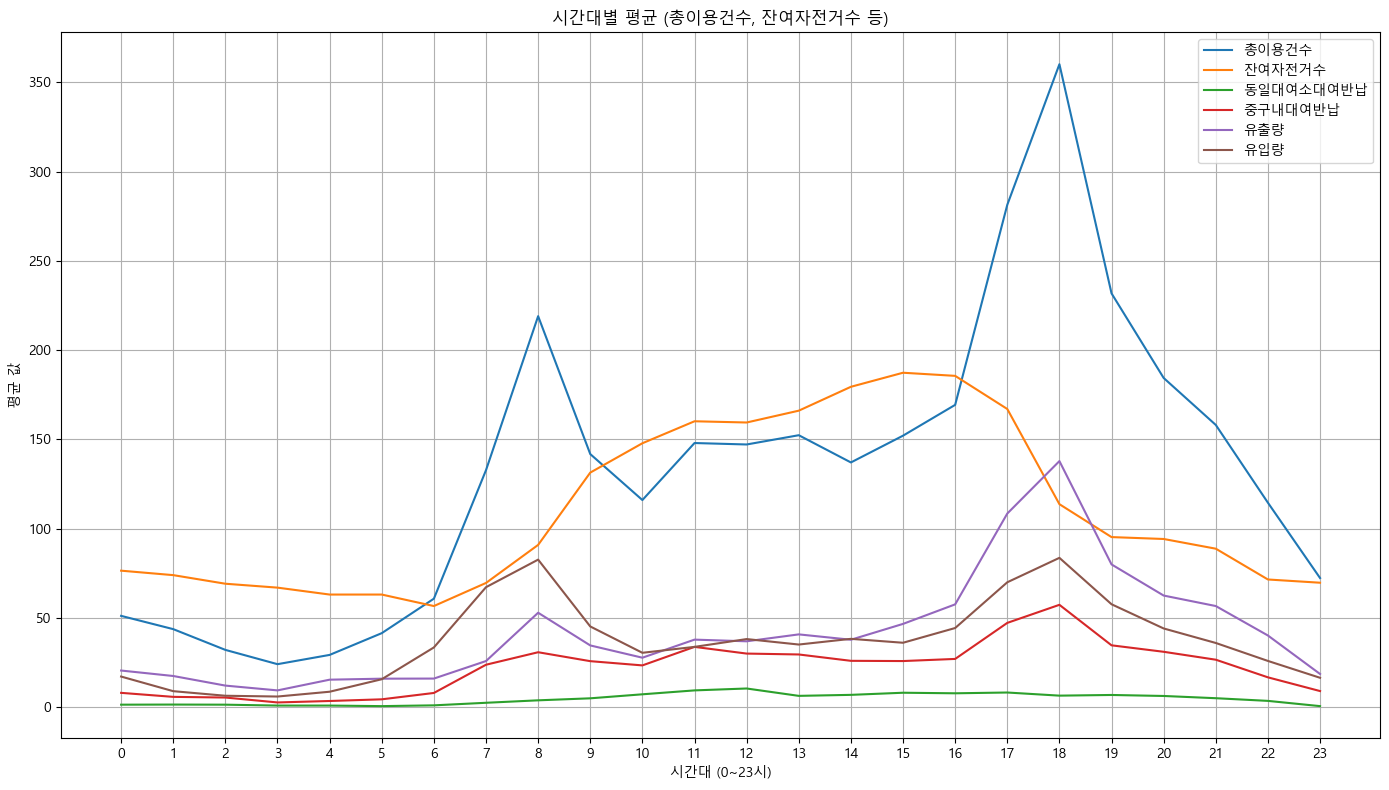

In [35]:
mean_by_hour = usage_station.groupby("시간대")[[
    "총이용건수",
    "잔여자전거수",
    "동일대여소대여반납",
    "중구내대여반납",
    "유출량",
    "유입량"
]].mean()

# 그래프 그리기
plt.figure(figsize=(14, 8))

for column in mean_by_hour.columns:
    plt.plot(mean_by_hour.index, mean_by_hour[column], label=column)

plt.title("시간대별 평균 (총이용건수, 잔여자전거수 등)")
plt.xlabel("시간대 (0~23시)")
plt.ylabel("평균 값")
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- 중구에 전체적인 특징을 가장 잘 보여줌

In [36]:
import folium

# usage_station 데이터프레임에서 대여소_ID, 위도, 경도 추출 (중복 제거)
station_locations = usage_station[['대여소_ID', '위도', '경도']].drop_duplicates()

# 지도 초기화 (첫 번째 대여소 위치 기준)
center_lat = station_locations.iloc[0]['위도']
center_lon = station_locations.iloc[0]['경도']
station_map = folium.Map(location=[center_lat, center_lon], zoom_start=15)

# 각 대여소에 마커 추가
for _, row in station_locations.iterrows():
    folium.Marker(
        location=[row['위도'], row['경도']],
        popup=f"대여소 ID: {row['대여소_ID']}"
    ).add_to(station_map)

# 지도 객체를 마지막에 위치시키면 바로 출력됨 (Jupyter, Colab에서만)
station_map


## 클러스터 1번의 모든 대여소의 대한 시각화

- ST-1440 : 황학동롯데캐슬 앞 (주거지)

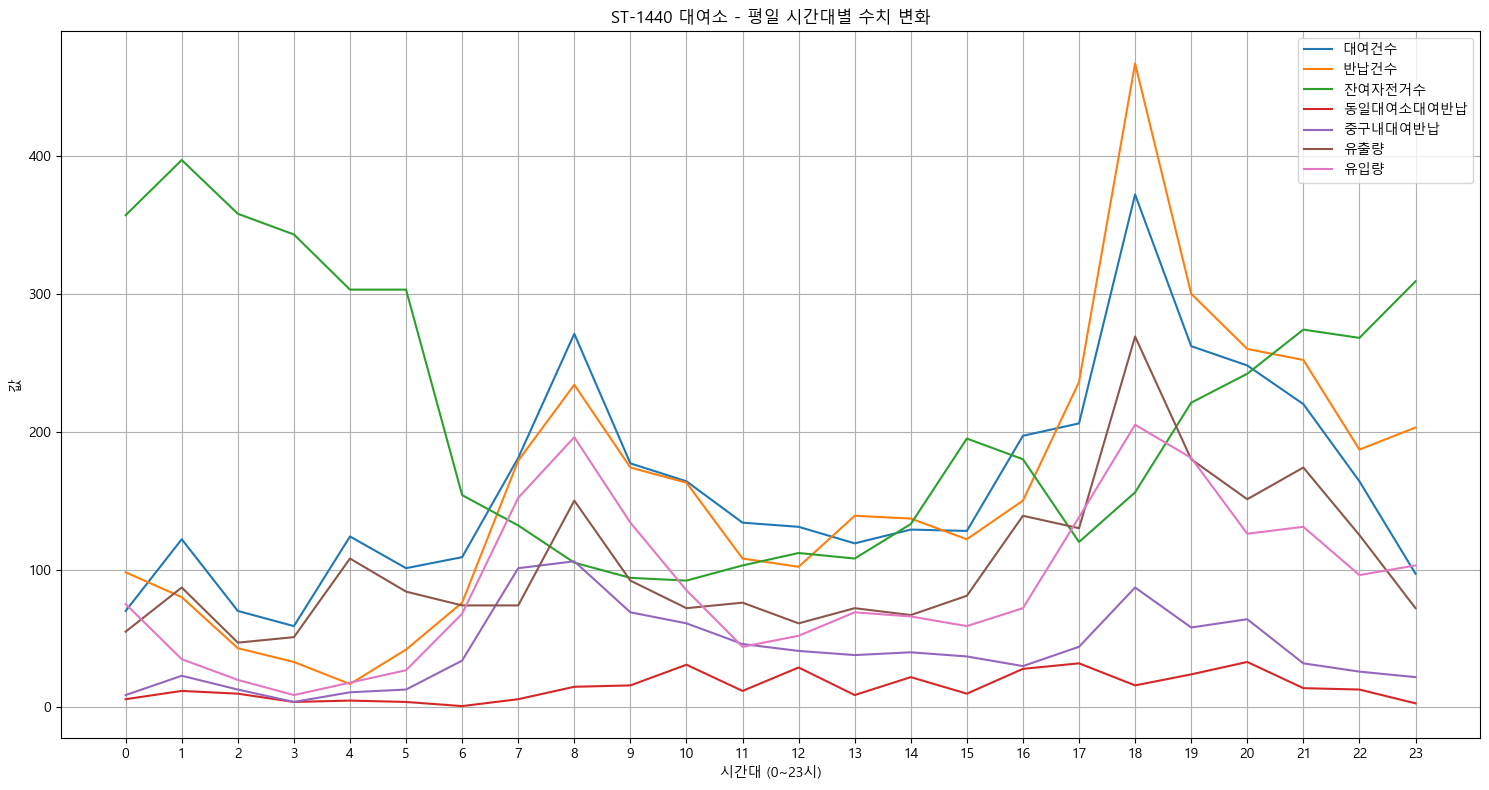

In [67]:
target_df = usage_station[(usage_station['대여소_ID'] == 'ST-1440') & (usage_station['주간'] == '평일')]


target_df = target_df.sort_values('시간대')


columns_to_plot = [
    '대여건수', '반납건수', '잔여자전거수',
    '동일대여소대여반납', '중구내대여반납', '유출량', '유입량'
]

# 4. 선그래프 그리기
plt.figure(figsize=(15, 8))

for col in columns_to_plot:
    plt.plot(target_df['시간대'], target_df[col], label=col)

plt.title("ST-1440 대여소 - 평일 시간대별 수치 변화")
plt.xlabel("시간대 (0~23시)")
plt.ylabel("값")
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))  # x축을 0~23으로 고정
plt.tight_layout()
plt.show()


- ST-1668, 을지로역 앞 (역앞)

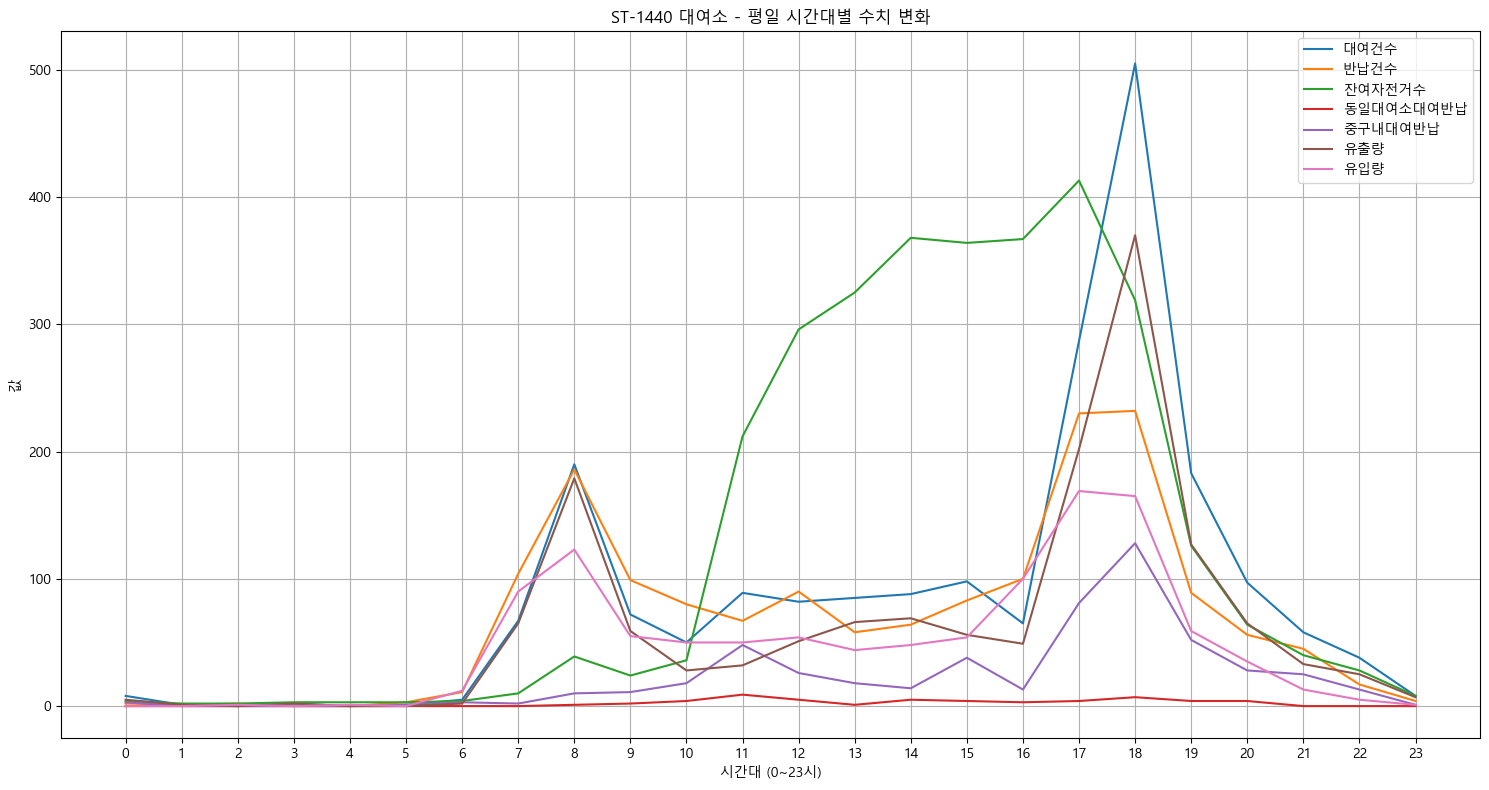

In [68]:
target_df = usage_station[(usage_station['대여소_ID'] == 'ST-1668') & (usage_station['주간'] == '평일')]


target_df = target_df.sort_values('시간대')


columns_to_plot = [
    '대여건수', '반납건수', '잔여자전거수',
    '동일대여소대여반납', '중구내대여반납', '유출량', '유입량'
]

# 4. 선그래프 그리기
plt.figure(figsize=(15, 8))

for col in columns_to_plot:
    plt.plot(target_df['시간대'], target_df[col], label=col)

plt.title("ST-1668 대여소 - 평일 시간대별 수치 변화")
plt.xlabel("시간대 (0~23시)")
plt.ylabel("값")
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))  # x축을 0~23으로 고정
plt.tight_layout()
plt.show()

- ST-1780 동역사역 앞 (역앞)

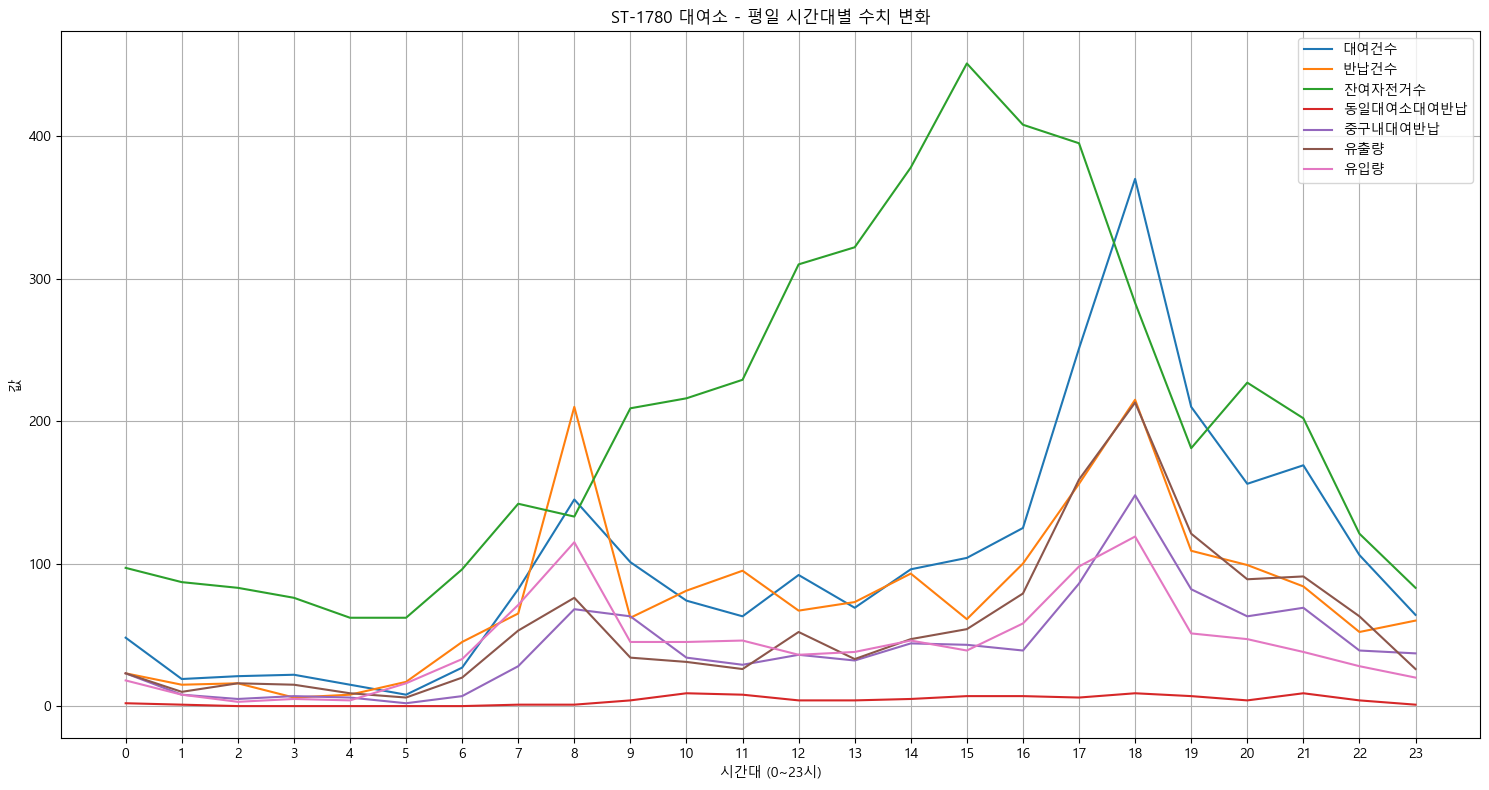

In [83]:
target_df = usage_station[(usage_station['대여소_ID'] == 'ST-1780') & (usage_station['주간'] == '평일')]


target_df = target_df.sort_values('시간대')


columns_to_plot = [
    '대여건수', '반납건수', '잔여자전거수',
    '동일대여소대여반납', '중구내대여반납', '유출량', '유입량'
]

# 4. 선그래프 그리기
plt.figure(figsize=(15, 8))

for col in columns_to_plot:
    plt.plot(target_df['시간대'], target_df[col], label=col)

plt.title("ST-1780 대여소 - 평일 시간대별 수치 변화")
plt.xlabel("시간대 (0~23시)")
plt.ylabel("값")
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))  # x축을 0~23으로 고정
plt.tight_layout()
plt.show()

- ST-185 시청역앞 (역앞)

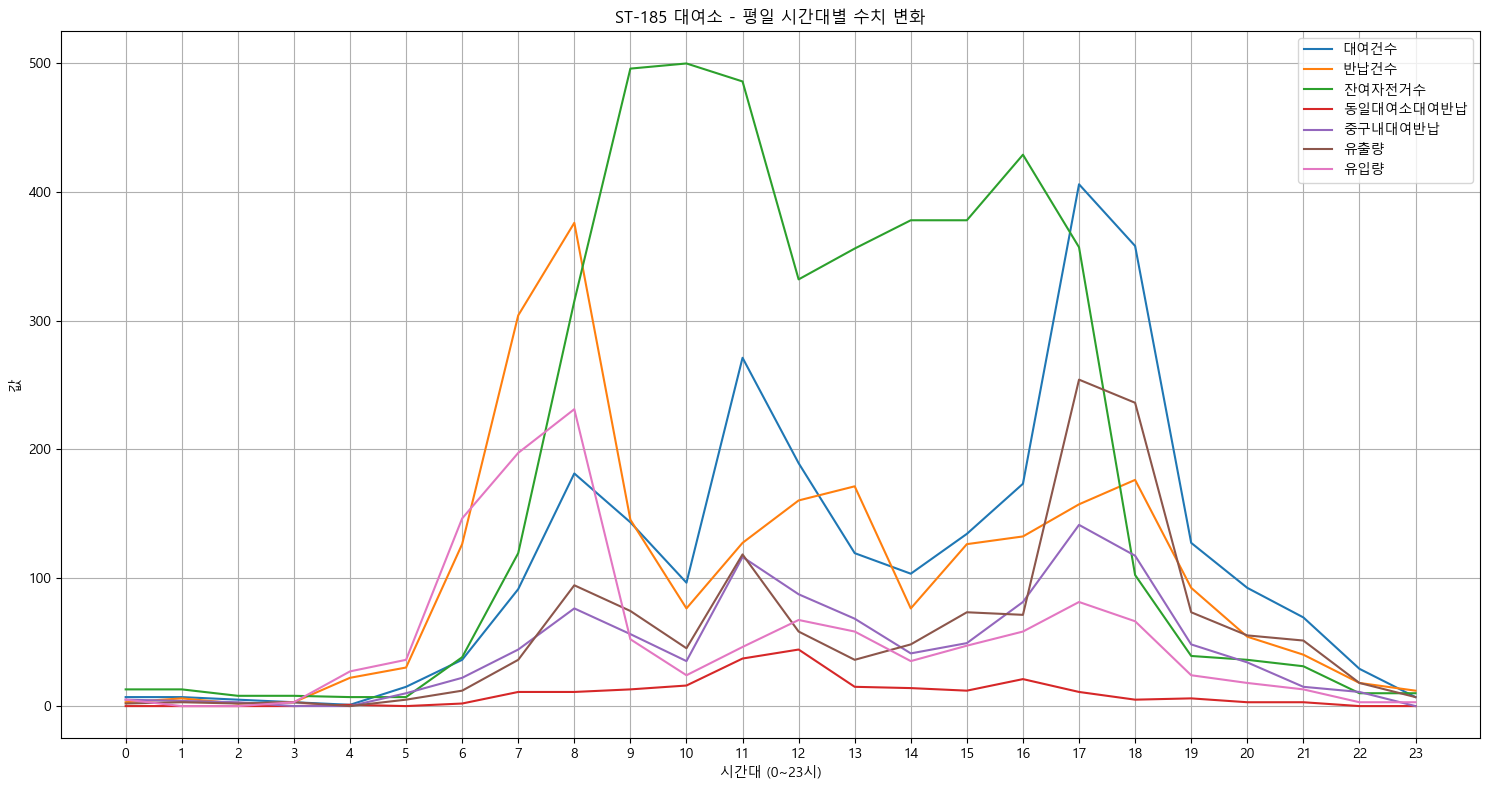

In [82]:
target_df = usage_station[(usage_station['대여소_ID'] == 'ST-185') & (usage_station['주간'] == '평일')]


target_df = target_df.sort_values('시간대')


columns_to_plot = [
    '대여건수', '반납건수', '잔여자전거수',
    '동일대여소대여반납', '중구내대여반납', '유출량', '유입량'
]

# 4. 선그래프 그리기
plt.figure(figsize=(15, 8))

for col in columns_to_plot:
    plt.plot(target_df['시간대'], target_df[col], label=col)

plt.title("ST-185 대여소 - 평일 시간대별 수치 변화")
plt.xlabel("시간대 (0~23시)")
plt.ylabel("값")
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))  # x축을 0~23으로 고정
plt.tight_layout()
plt.show()

- ST-198 신당역 (역앞)

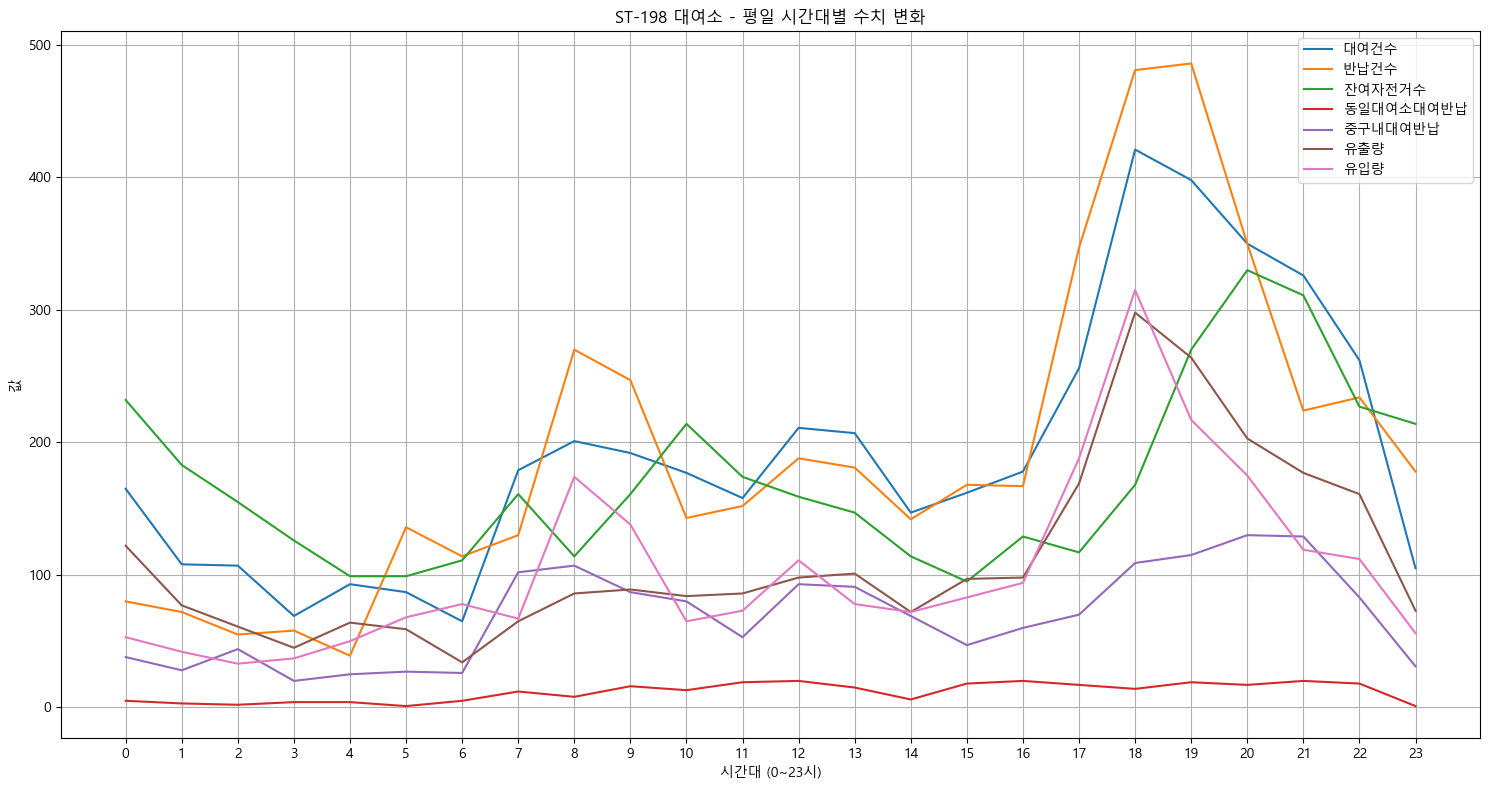

In [81]:
target_df = usage_station[(usage_station['대여소_ID'] == 'ST-198') & (usage_station['주간'] == '평일')]


target_df = target_df.sort_values('시간대')


columns_to_plot = [
    '대여건수', '반납건수', '잔여자전거수',
    '동일대여소대여반납', '중구내대여반납', '유출량', '유입량'
]

# 4. 선그래프 그리기
plt.figure(figsize=(15, 8))

for col in columns_to_plot:
    plt.plot(target_df['시간대'], target_df[col], label=col)

plt.title("ST-198 대여소 - 평일 시간대별 수치 변화")
plt.xlabel("시간대 (0~23시)")
plt.ylabel("값")
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))  # x축을 0~23으로 고정
plt.tight_layout()
plt.show()

- ST-2422 장교빌딩 (오피스밀집지역)

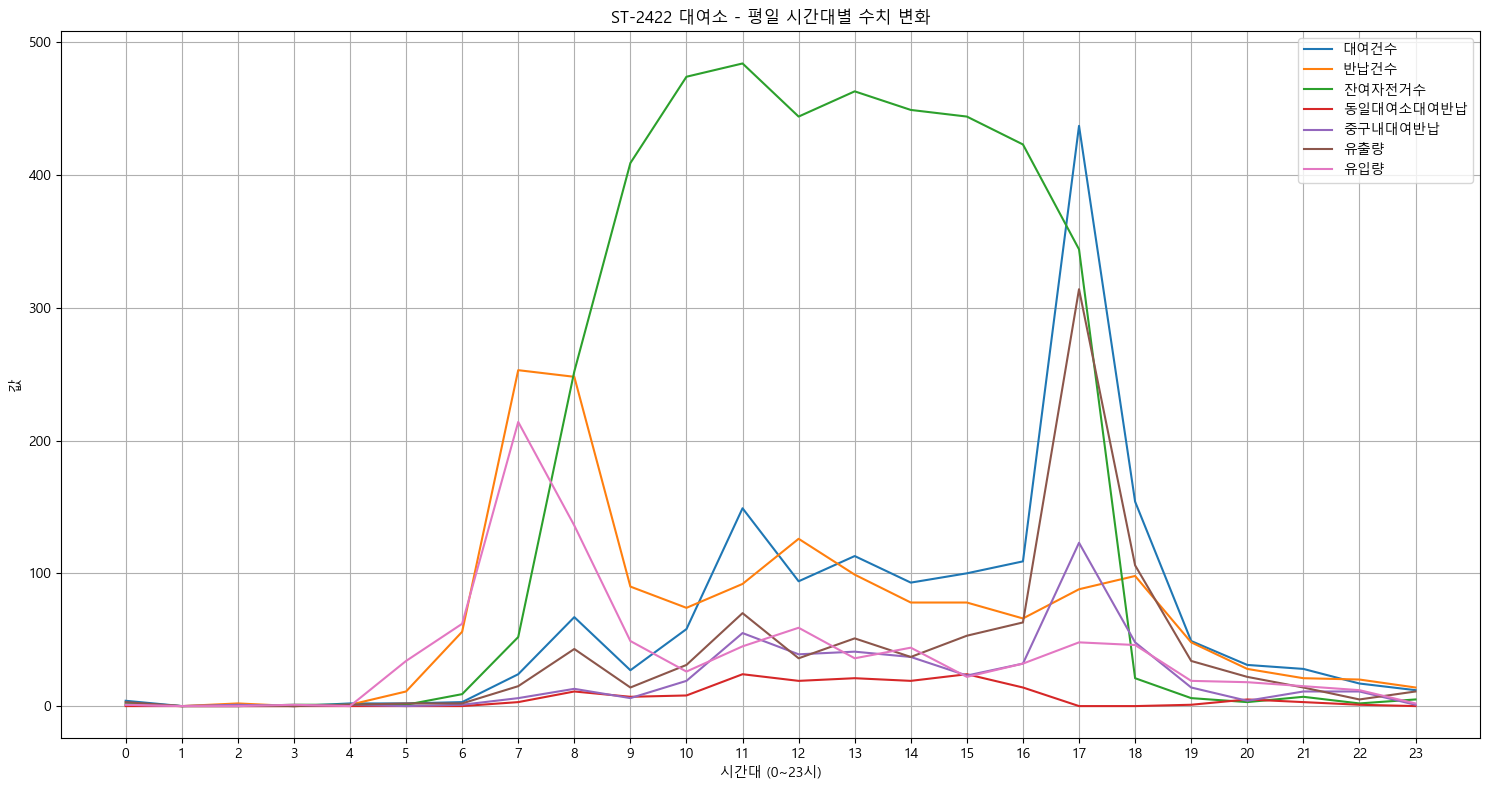

In [80]:
target_df = usage_station[(usage_station['대여소_ID'] == 'ST-2422') & (usage_station['주간'] == '평일')]


target_df = target_df.sort_values('시간대')


columns_to_plot = [
    '대여건수', '반납건수', '잔여자전거수',
    '동일대여소대여반납', '중구내대여반납', '유출량', '유입량'
]

# 4. 선그래프 그리기
plt.figure(figsize=(15, 8))

for col in columns_to_plot:
    plt.plot(target_df['시간대'], target_df[col], label=col)

plt.title("ST-2422 대여소 - 평일 시간대별 수치 변화")
plt.xlabel("시간대 (0~23시)")
plt.ylabel("값")
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))  # x축을 0~23으로 고정
plt.tight_layout()
plt.show()

- ST-2693(오피스밀집지역) 

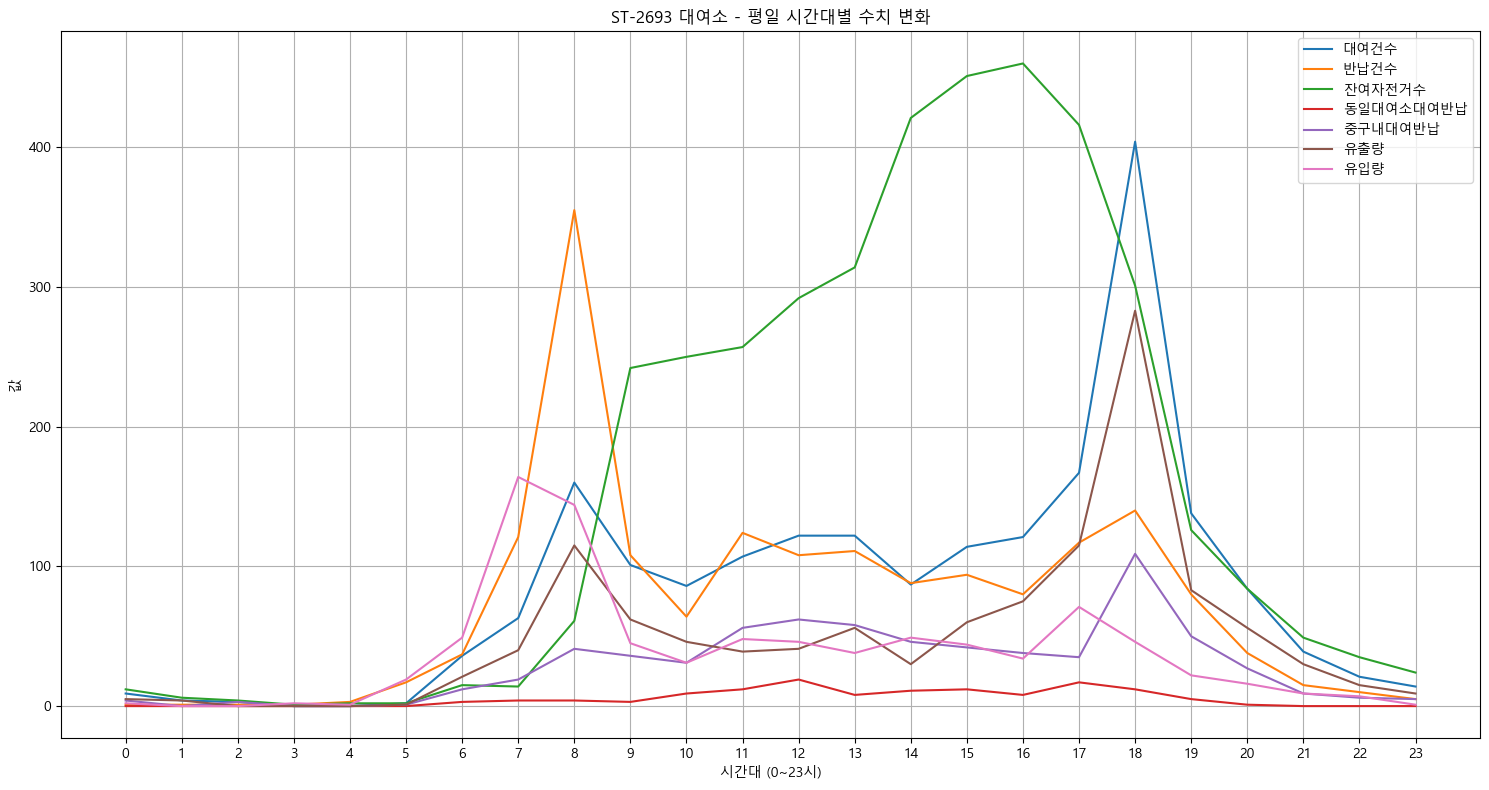

In [79]:
target_df = usage_station[(usage_station['대여소_ID'] == 'ST-2693') & (usage_station['주간'] == '평일')]


target_df = target_df.sort_values('시간대')


columns_to_plot = [
    '대여건수', '반납건수', '잔여자전거수',
    '동일대여소대여반납', '중구내대여반납', '유출량', '유입량'
]

# 4. 선그래프 그리기
plt.figure(figsize=(15, 8))

for col in columns_to_plot:
    plt.plot(target_df['시간대'], target_df[col], label=col)

plt.title("ST-2693 대여소 - 평일 시간대별 수치 변화")
plt.xlabel("시간대 (0~23시)")
plt.ylabel("값")
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))  # x축을 0~23으로 고정
plt.tight_layout()
plt.show()

- ST-2903 롯데캐슬베네치아아파트(주거지)

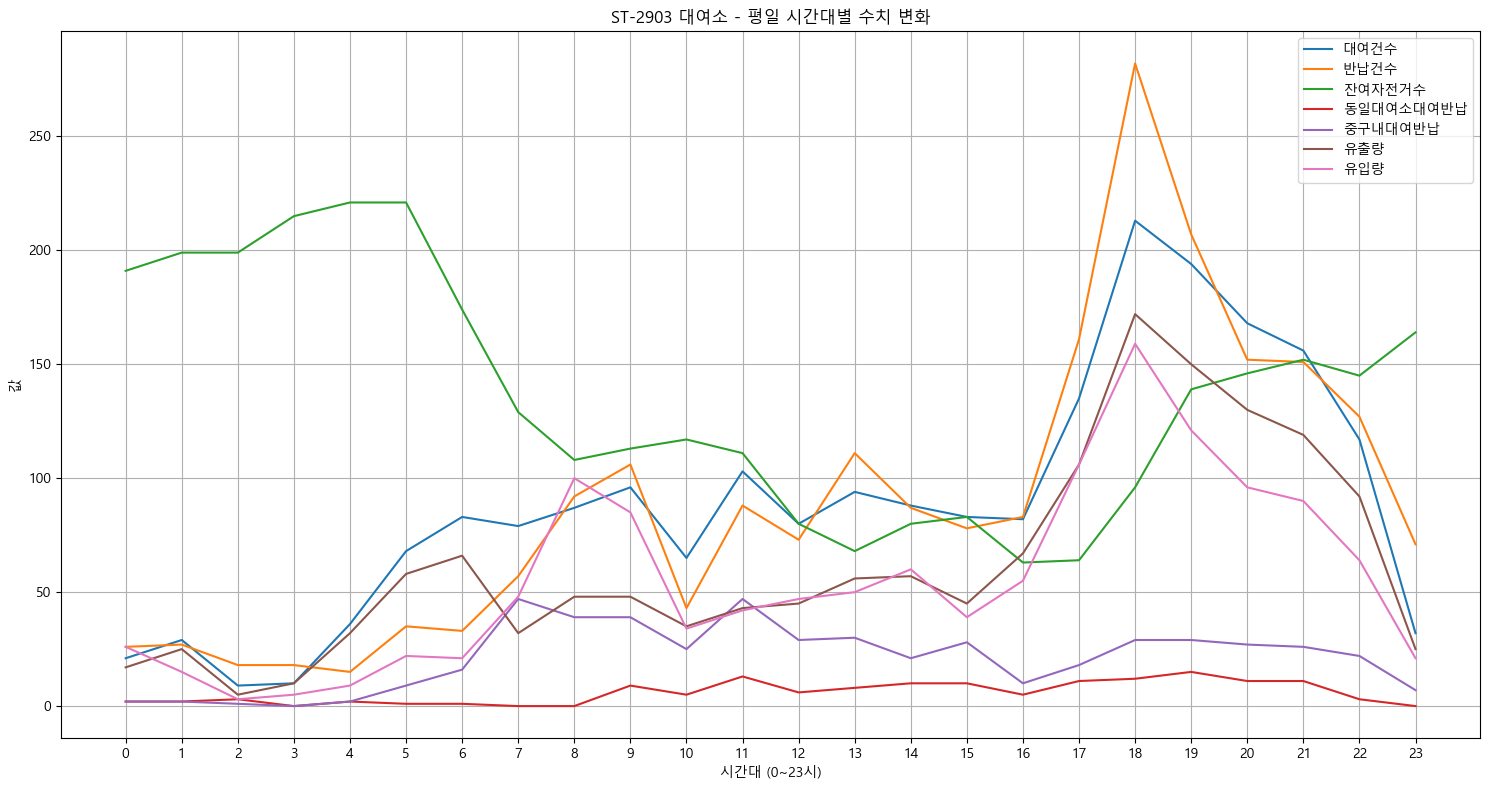

In [78]:
target_df = usage_station[(usage_station['대여소_ID'] == 'ST-2903') & (usage_station['주간'] == '평일')]


target_df = target_df.sort_values('시간대')


columns_to_plot = [
    '대여건수', '반납건수', '잔여자전거수',
    '동일대여소대여반납', '중구내대여반납', '유출량', '유입량'
]

# 4. 선그래프 그리기
plt.figure(figsize=(15, 8))

for col in columns_to_plot:
    plt.plot(target_df['시간대'], target_df[col], label=col)

plt.title("ST-2903 대여소 - 평일 시간대별 수치 변화")
plt.xlabel("시간대 (0~23시)")
plt.ylabel("값")
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))  # x축을 0~23으로 고정
plt.tight_layout()
plt.show()

## 1클러스터의 세부특징
- 거치소 주변 도메인 정보를 기반으로, 대여소와 인접한 주요 건물 유형을 파악하여 분류
1. 주거지 ST-1440, ST-2903 :
   - 새벽 5시부터 유출량과 대여량이 급증 → 출근 시간대로 추정
   - 이후 다소 감소하긴 하나, 오후 시간대에도 일정 수준의 대여량이 유지됨
   - 오후 16시부터 반납량이 급증 → 퇴근 시간대 자전거 귀환으로 해석 가능
2. 지하철앞 ST-1668, ST-1780, ST-185, ST-198 :
   - 오전 6시부터 대여건수 및 반납건수가 모두 급증 → 역세권 통근 수요 반영
   - 반납건수가 다소 우세하며, 9시부터 잔여 자전거 수가 증가점심시간에는 대여량 감소, 이후 오후 16시부터 대여량 급증, 잔여 자전거 수 급감 → 퇴근 수요 반영
4. 오피스 밀집 지역 ST-2693, ST-2422 :
   - 오전 7시부터 반납건수만 급증 → 회사 출근 시 반납 수요
   - 오전 8시부터 잔여 자전거 수가 증가 → 자전거 공급 포화 상태
   - 점심시간에는 대여건수와 반납건수가 유사하게 발생
   - 오후 17시부터 대여량만 급등, 반면 잔여 자전거 수는 급격히 감소 → 퇴근과 외부 이동 수요 집중

# 전체 특징 & 정리
- 주거지, 지하철앞, 오피스밀집지역 이렇게 3가지로 나옴
- 1번 클러스터 모든 대여소가 출근시간, 퇴근시간에 총 이용량은 급등함
- 주거지 지역에는
  - 오전 : 대여량 급등, 잔여자전거량급락, 출근시간을 제외한 오전시간에는 대여량, 반납량 고루고루 있음(주변 상가이용), 중구내대여반납, 동일대여소대여반납이 올라감
  - 오후 : 12~16시까지는 대여반납수가 고루고루 존재, 16시 이후부터는 반납량, 유입량이 급등, 잔여자전거 수 증가
- 지하철 앞
  - 오전 : 오전 7시부터 9시까지 반납량 급등, 자전거수 급등, 9시 이후로는 대여량 또한 급등(지하철 이용객들)
  - 오후 : 대여량, 반납량 모두 고루고루존재, 대여량, 반납량 모두 급등 역마다 다르지만 대부분의 역들이 반납량이 증가가 제일 크지만 ST-198 신당역만 대여량이 반납량보다 큼
- 오피스밀집지역 : 오전 : 반납량 급증
                  오후 : 대여량 급증 명확함

- 이용건수만 따진다면 모든 지역의 오후 퇴근시간때 총이용량이 많음
- 오전 11시부터 오후 3시까지는 중구 내 대여소이동이 유입, 유출을 역전할 때가 있지만 대다수 모든 시간 다른 지역구로 이동함

- 출근 및 퇴근 시간대에는 대여 또는 반납 중 한쪽으로 이용량이 급격히 쏠리는 현상이 나타남. 이로 인해 잔여 자전거 수의 격차가 심화되며, 특정 시간대에 자전거가 부족하거나 과잉되는 수요 불균형이 발생. 이러한 경향은 1번 클러스터뿐 아니라 0번 클러스터에서도 유사하게 나타나며, 단지 규모만 작을 뿐 전체적인 패턴은 거의 동일. 결과적으로, 중구 전반에 걸쳐 출퇴근 시간대의 수요 불균형이 구조적으로 반복되고 있는 것으로 분석.

# 그 이외의 자치구들의 클러스터링
- 규모로 인해 나눠지는 현상은 나타나지만 사용목적별등 특별한 특이점은 보이지 않음
- 한계점임

In [37]:
result = result[result["cluster"] != 1]

In [38]:
result = result.drop(["cluster"], axis = 1)

In [39]:
result.head()

,대여소_ID,대여소번호,총대여건수,총반납건수,총이용건수,평균_잔여자전거수,표준편차_잔여자전거수,총유출량,총유입량,총동일대여소반납,순유출량,순유입량,동일반납비율
0,ST-116,300,1104,1137,2241,13.812500,13.229008,573,648,43,-75,75,0.019188
1,ST-126,310,1548,1387,2935,27.708333,48.734172,979,758,67,221,-221,0.022828
2,ST-134,318,1403,1365,2768,50.166667,88.466446,833,808,98,25,-25,0.035405
3,ST-136,320,1727,1712,3439,51.062500,78.981928,1008,1019,180,-11,11,0.052341
4,ST-137,321,1308,1311,2619,41.625000,58.341484,667,640,136,27,-27,0.051928


In [40]:
result.tail()

,대여소_ID,대여소번호,총대여건수,총반납건수,총이용건수,평균_잔여자전거수,표준편차_잔여자전거수,총유출량,총유입량,총동일대여소반납,순유출량,순유입량,동일반납비율
85,ST-338,387,1429,1108,2537,73.500000,40.521599,718,499,124,219,-219,0.048877
86,ST-943,389,1356,1369,2725,26.062500,17.492133,835,895,71,-60,60,0.026055
87,ST-944,390,962,977,1939,11.979167,7.985331,324,331,85,-7,7,0.043837
88,ST-946,826,1524,1584,3108,96.291667,53.011825,1025,945,52,80,-80,0.016731
89,ST-977,391,1019,1000,2019,31.000000,35.984630,587,616,58,-29,29,0.028727


In [41]:
x = result[feature_cols]

In [42]:
scaler = StandardScaler()

In [43]:
x_scaled = scaler.fit_transform(x)

C:\Users\dbtjd\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\dbtjd\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\dbtjd\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\dbtjd\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

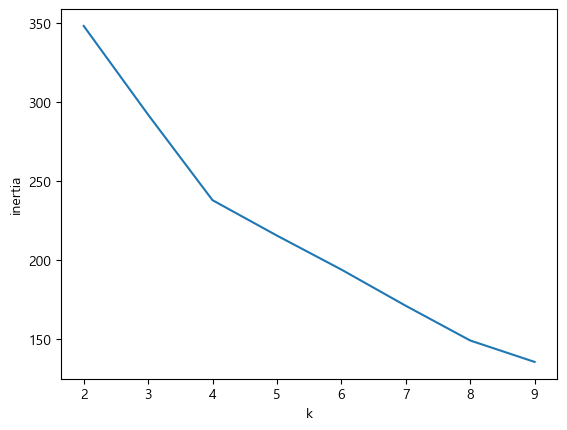

In [44]:
# k를 2부터 10까지 해서 최적의 k 값 찾기
inertia = []

for k in range(2,10) :
    km = KMeans(n_clusters = k, random_state = 26)
    km.fit(x_scaled)
    inertia.append(km.inertia_)

plt.plot(range(2, 10), inertia)
plt.xlabel("k")
plt.ylabel("inertia")
plt.show()

In [45]:
model = KMeans(n_clusters = 4, n_init = 10, random_state = 26)

In [46]:
labels = model.fit_predict(x_scaled)

C:\Users\dbtjd\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [47]:
result["cluster"] = labels

In [48]:
result["cluster"].value_counts()

cluster
1    34
2    26
0    16
3     6
Name: count, dtype: int64

In [49]:
result = result.sort_values("cluster").reset_index(drop=True)

In [50]:
result

,대여소_ID,대여소번호,총대여건수,총반납건수,총이용건수,평균_잔여자전거수,표준편차_잔여자전거수,총유출량,총유입량,총동일대여소반납,순유출량,순유입량,동일반납비율,cluster
0,ST-1778,472,1314,1260,2574,49.916667,88.543254,744,749,116,-5,5,0.045066,0
1,ST-1779,473,2334,2209,4543,30.895833,26.954840,1098,946,204,152,-152,0.044904,0
2,ST-946,826,1524,1584,3108,96.291667,53.011825,1025,945,52,80,-80,0.016731,0
3,ST-189,374,2036,2009,4045,64.541667,22.862176,851,744,156,107,-107,0.038566,0
4,ST-1771,445,1894,1901,3795,59.083333,94.314736,915,926,133,-11,11,0.035046,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,ST-3053,4801,762,166,928,36.125000,10.977007,419,99,9,320,-320,0.009698,3
78,ST-1669,434,612,62,674,53.104167,45.213084,378,36,8,342,-342,0.011869,3
79,ST-338,387,1429,1108,2537,73.500000,40.521599,718,499,124,219,-219,0.048877,3
80,ST-1436,399,949,663,1612,81.770833,34.744196,561,336,29,225,-225,0.017990,3


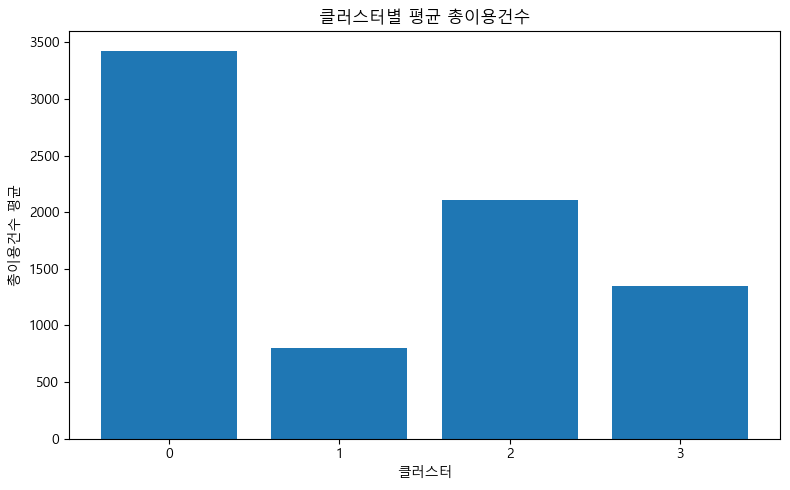

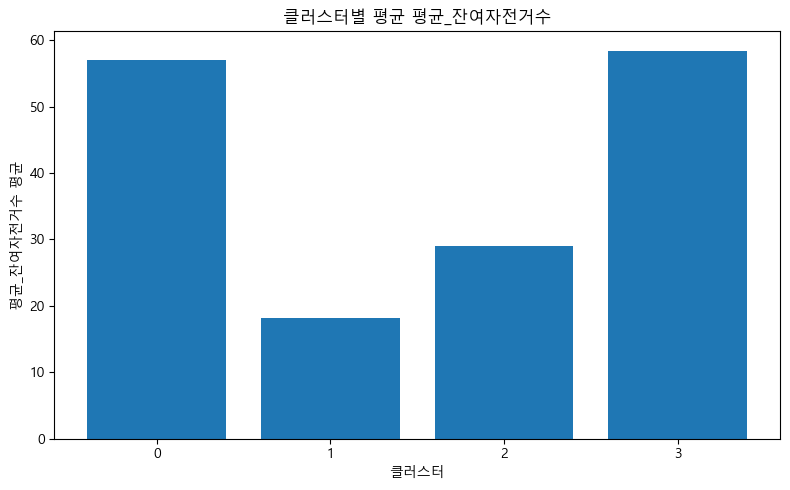

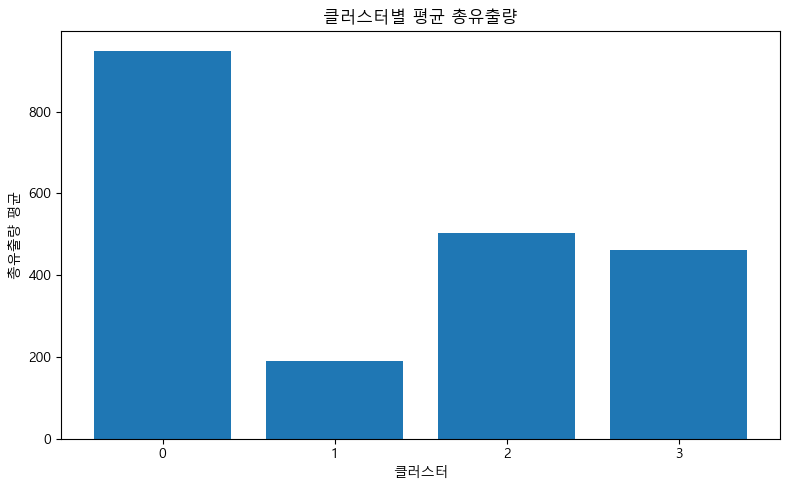

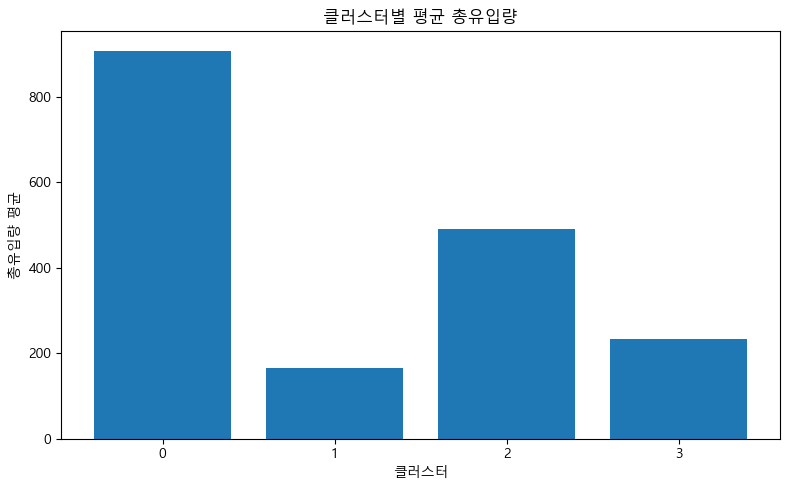

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) 그래프로 뽑을 4개 지표
metrics = [
    "총이용건수",
    "평균_잔여자전거수",
    "총유출량",
    "총유입량",
]

# 2) 클러스터별 평균 집계
#    (result에 'cluster'와 위 컬럼들이 존재한다고 가정)
grouped = result.groupby("cluster")[metrics].mean().sort_index()

# 3) 각 지표를 '별도' 그래프로 출력 (총 4개)
for m in metrics:
    plt.figure(figsize=(8, 5))
    plt.bar(grouped.index.astype(str), grouped[m].values)
    plt.title(f"클러스터별 평균 {m}")
    plt.xlabel("클러스터")
    plt.ylabel(f"{m} 평균")
    plt.tight_layout()
    plt.show()


In [52]:
zero_cl = result[result["cluster"] == 0]["대여소_ID"].unique()
one_cl = result[result["cluster"] == 1]["대여소_ID"].unique()
two_cl = result[result["cluster"] == 2]["대여소_ID"].unique()
three_cl = result[result["cluster"] == 3]["대여소_ID"].unique()

In [53]:
zero_station = loc_merge[loc_merge["대여소_ID"].isin(zero_cl)]
one_station = loc_merge[loc_merge["대여소_ID"].isin(one_cl)]
two_station = loc_merge[loc_merge["대여소_ID"].isin(two_cl)]
three_station = loc_merge[loc_merge["대여소_ID"].isin(three_cl)]

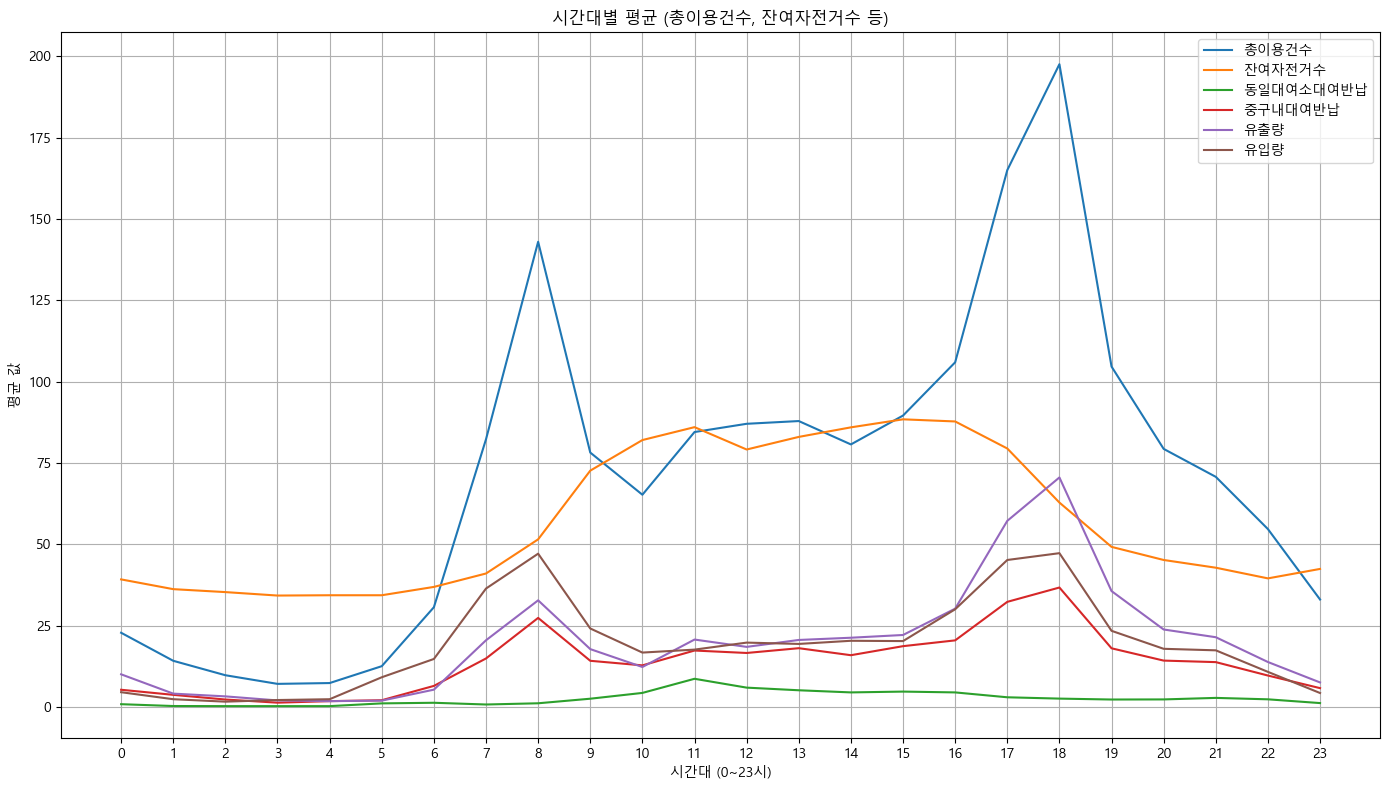

In [54]:
mean_by_hour = zero_station.groupby("시간대")[[
    "총이용건수",
    "잔여자전거수",
    "동일대여소대여반납",
    "중구내대여반납",
    "유출량",
    "유입량"
]].mean()

# 그래프 그리기
plt.figure(figsize=(14, 8))

for column in mean_by_hour.columns:
    plt.plot(mean_by_hour.index, mean_by_hour[column], label=column)

plt.title("시간대별 평균 (총이용건수, 잔여자전거수 등)")
plt.xlabel("시간대 (0~23시)")
plt.ylabel("평균 값")
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

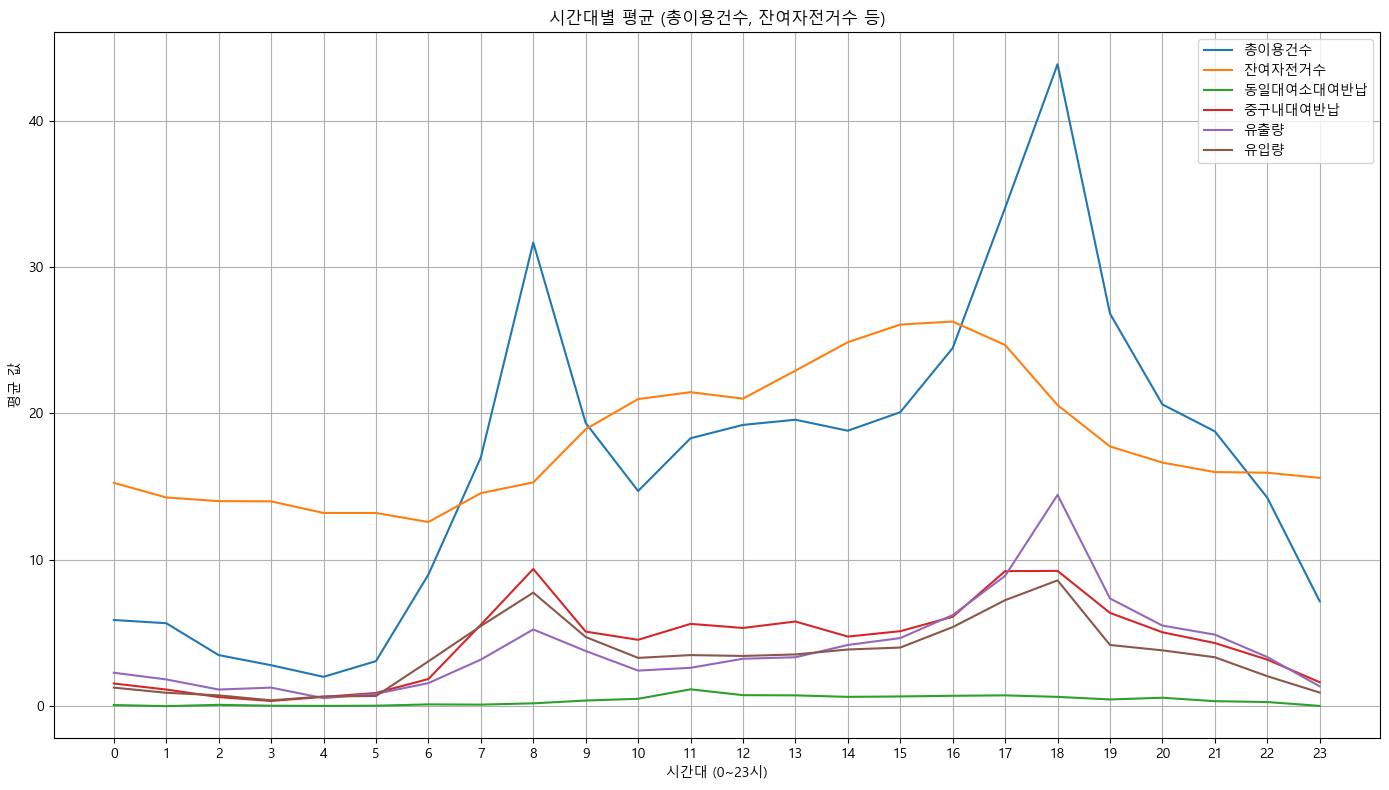

In [55]:
mean_by_hour = one_station.groupby("시간대")[[
    "총이용건수",
    "잔여자전거수",
    "동일대여소대여반납",
    "중구내대여반납",
    "유출량",
    "유입량"
]].mean()

# 그래프 그리기
plt.figure(figsize=(14, 8))

for column in mean_by_hour.columns:
    plt.plot(mean_by_hour.index, mean_by_hour[column], label=column)

plt.title("시간대별 평균 (총이용건수, 잔여자전거수 등)")
plt.xlabel("시간대 (0~23시)")
plt.ylabel("평균 값")
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

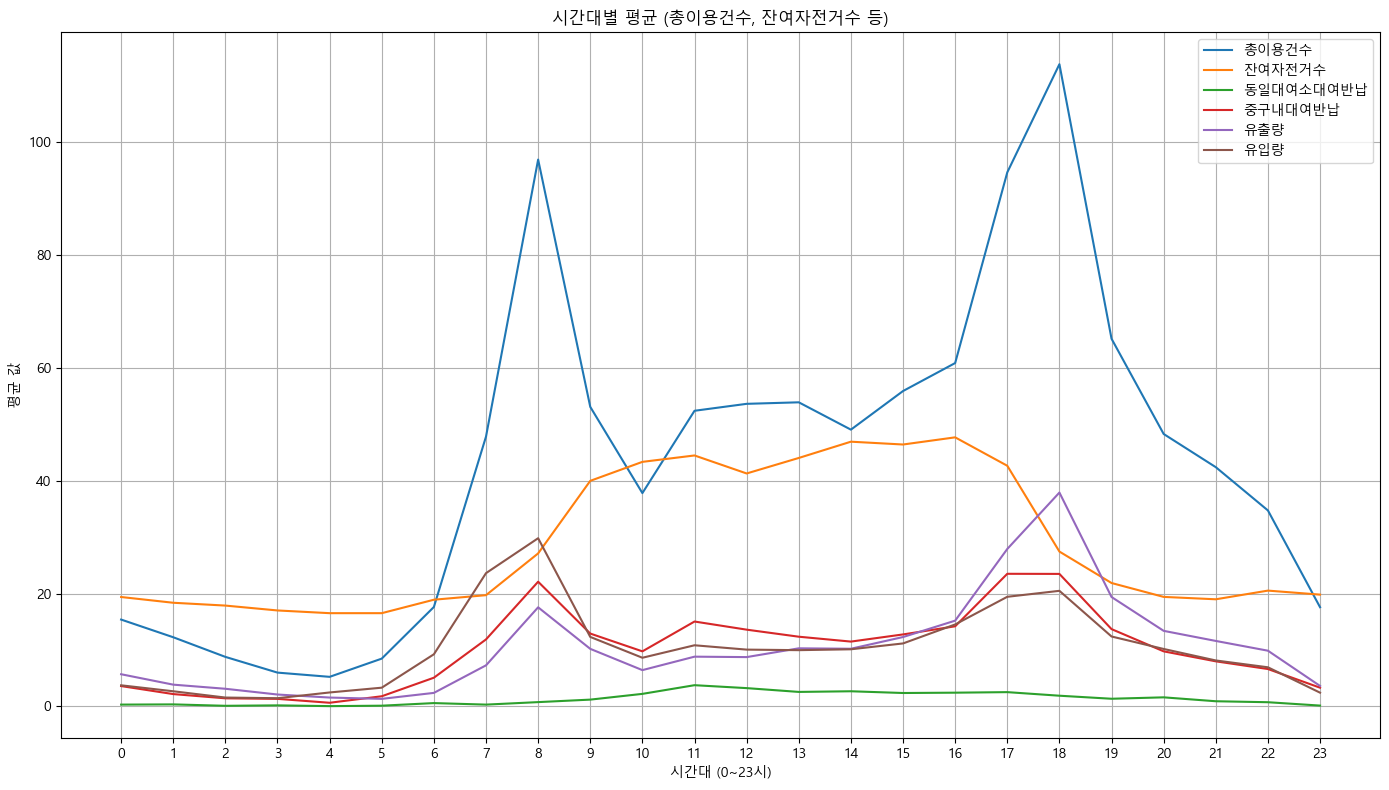

In [56]:
mean_by_hour = two_station.groupby("시간대")[[
    "총이용건수",
    "잔여자전거수",
    "동일대여소대여반납",
    "중구내대여반납",
    "유출량",
    "유입량"
]].mean()

# 그래프 그리기
plt.figure(figsize=(14, 8))

for column in mean_by_hour.columns:
    plt.plot(mean_by_hour.index, mean_by_hour[column], label=column)

plt.title("시간대별 평균 (총이용건수, 잔여자전거수 등)")
plt.xlabel("시간대 (0~23시)")
plt.ylabel("평균 값")
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

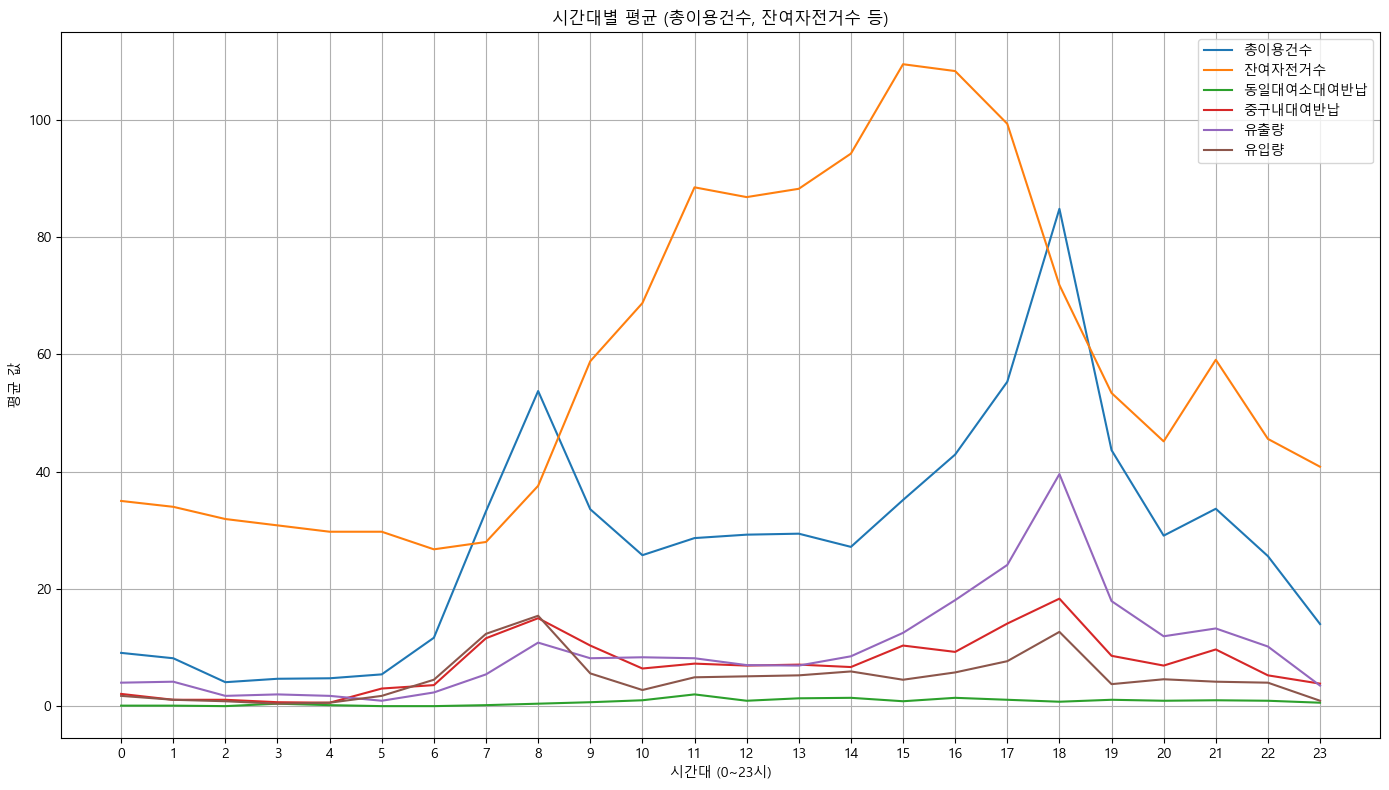

In [57]:
mean_by_hour = three_station.groupby("시간대")[[
    "총이용건수",
    "잔여자전거수",
    "동일대여소대여반납",
    "중구내대여반납",
    "유출량",
    "유입량"
]].mean()

# 그래프 그리기
plt.figure(figsize=(14, 8))

for column in mean_by_hour.columns:
    plt.plot(mean_by_hour.index, mean_by_hour[column], label=column)

plt.title("시간대별 평균 (총이용건수, 잔여자전거수 등)")
plt.xlabel("시간대 (0~23시)")
plt.ylabel("평균 값")
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [58]:
import pandas as pd

# 공통 처리 함수
def pick_coords_with_cluster(df, cluster_id):
    cols = ["대여소_ID", "위도", "경도"]
    out = (
        df[cols]
        .dropna(subset=["위도", "경도"])                # 좌표 결측 제거
        .drop_duplicates(subset=["대여소_ID"], keep="first")  # 대여소_ID 중복 한 개만
        .copy()
    )
    out["cluster"] = cluster_id
    return out

# 각 데이터프레임을 클러스터 라벨과 함께 축약
z0 = pick_coords_with_cluster(zero_station,   0)
z1 = pick_coords_with_cluster(one_station,    1)
z2 = pick_coords_with_cluster(two_station,    2)
z3 = pick_coords_with_cluster(three_station,  3)
z4 = pick_coords_with_cluster(usage_station,  4)

# 모두 합치기 (같은 대여소_ID가 여러 DF에 있으면 행이 여러 개 생기며,
# 어느 원본에서 왔는지 cluster로 구분 가능)
cluster_coords = pd.concat([z0, z1, z2, z3, z4], ignore_index=True)

# 필요하면 저장
# cluster_coords.to_csv("cluster_station_coords.csv", index=False, encoding="utf-8-sig")

cluster_coords.head()


,대여소_ID,위도,경도,cluster
0,ST-126,37.568878,126.977470,0
1,ST-134,37.568634,126.982315,0
2,ST-136,37.566223,126.983589,0
3,ST-137,37.565464,126.984138,0
4,ST-1435,37.566605,126.992493,0


In [59]:
import folium
from folium.features import DivIcon

# 1) 준비: 데이터 확인 & 중심점
plot_df = cluster_coords.dropna(subset=["위도","경도"]).copy()
plot_df["cluster"] = plot_df["cluster"].astype(int)

center = [plot_df["위도"].mean(), plot_df["경도"].mean()]
m = folium.Map(location=center, zoom_start=13, tiles="CartoDB positron")

# 2) 클러스터별 색상(원하면 바꿔도 OK)
color_map = {0:"red", 1:"blue", 2:"green", 3:"purple", 4:"orange"}

# 3) 클러스터별 레이어(토글 가능) + 개별 마커 & 라벨(DivIcon)
for c in sorted(plot_df["cluster"].unique()):
    fg = folium.FeatureGroup(name=f"Cluster {c}", show=True)
    sub = plot_df[plot_df["cluster"] == c]

    for _, r in sub.iterrows():
        # (a) 점 마커 — 항상 표시
        folium.CircleMarker(
            location=[r["위도"], r["경도"]],
            radius=5,
            color=color_map.get(c, "gray"),
            fill=True,
            fill_opacity=0.9,
            tooltip=f"{r['대여소_ID']} (cluster {c})",
            popup=f"대여소_ID: {r['대여소_ID']}<br>Cluster: {c}"
        ).add_to(fg)

        # (b) 텍스트 라벨 — 마커 옆에 항상 표시
        folium.Marker(
            location=[r["위도"], r["경도"]],
            icon=DivIcon(
                icon_size=(1,1),
                icon_anchor=(0,0),  # 좌상단 기준
                html=f"""
                <div style="
                    font-size: 11px; 
                    font-weight: 600; 
                    color: {color_map.get(c,'gray')};
                    background: rgba(255,255,255,0.7);
                    padding: 2px 3px; 
                    border-radius: 3px;
                    transform: translate(8px, -8px);  /* 마커와 살짝 간격 */
                    white-space: nowrap;">
                    C{c}
                </div>
                """
            )
        ).add_to(fg)

    fg.add_to(m)

# 4) 레이어 컨트롤(클러스터별 켜고 끄기)
folium.LayerControl(collapsed=False).add_to(m)

# ⭐ 저장하지 않고 노트북에서 바로 보기
m
